In [5]:
import scipy
from data import One_RNA_Dataset
import pandas as pd
from gae import get_vanilla_model
import torch
from tqdm import tqdm
# Multiprocessing using torch.multiprocessing
import torch.multiprocessing as mp
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from time import time
from sklearn.cluster import AgglomerativeClustering
# Grid search
from sklearn.model_selection import GridSearchCV
from torch_geometric.nn import ResGatedGraphConv

# Compute embeddings

In [2]:
dataset = One_RNA_Dataset(root='../data/test/')

In [7]:
model = get_vanilla_model(256, layer=ResGatedGraphConv)
model.load_state_dict(torch.load('../models/resgatedgraphconv256L1/best_model.pt'))

device = torch.device('cuda')
model = model.to(device)

In [8]:
df = pd.DataFrame(columns=['id', 'pred_embedding'])
for i in tqdm(range(len(dataset))):
    data = dataset[i]
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    with torch.no_grad():
        pred = model.encode(data.x, data.edge_index)
    df.loc[i] = [i, pred.cpu().numpy()]

100%|██████████| 1000/1000 [00:02<00:00, 419.17it/s]


# Speed HCA

In [76]:
# HCA clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
from time import time

nb_iter = 100
deb = time()

# for _ in range(nb_iter):
X_e = np.array(df['pred_embedding'].tolist())
X_e = np.mean(X_e, axis=1)

hca_clustering1 = AgglomerativeClustering(n_clusters=None, distance_threshold=0, metric='precomputed', linkage='complete')
hca_clustering1.fit(X)

# print((time() - deb)/nb_iter)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='precomputed', n_clusters=None)

In [6]:
silhouette_score(X, hca_clustering.labels_)

ValueError: Number of labels is 1000. Valid values are 2 to n_samples - 1 (inclusive)

# Demo visualization HCA

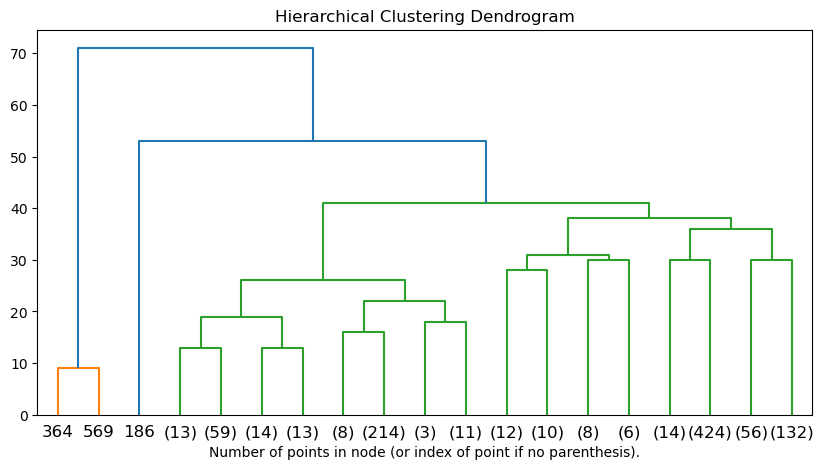

In [84]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(10, 5))
plot_dendrogram(hca_clustering1, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

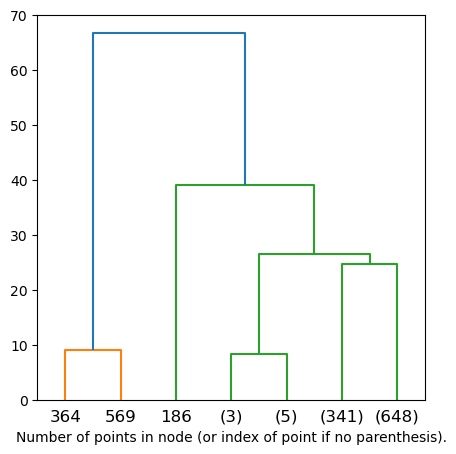

In [20]:
plt.figure(figsize=(5, 5))
plot_dendrogram(hca_clustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [10]:
X =torch.load('../data/test/distance_matrix.pt')

In [ ]:
hca_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, metric='precomputed', linkage='average')
hca_clustering.fit(X)

# Speed K-Means

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [11]:
# K-Means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

nb_iter = 10
deb = time()
for _ in tqdm(range(nb_iter)):
    X = np.array(df['pred_embedding'].tolist())
    X = np.mean(X, axis=1)


    clustering = KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=300, tol=0.0001)
    clustering.fit(X)
print((time() - deb)/nb_iter)
    

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

0.8562524795532227


In [23]:
# Test with dissimilarity matrix
clustering_dissimilarity = KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=300, tol=0.0001)
clustering_dissimilarity.fit(X)

KMeans(n_clusters=2, n_init=5)

In [17]:
silhouette_score(X, clustering.labels_)


0.6241598853216944

# Computation dissimilarity matrix

In [26]:
# Compare with dissimilarity matrix from base pair distance matrix
import numpy as np
from matplotlib import pyplot as plt
from utils import base_pair_distance
from data import PairDataset
from torch_geometric.data import DataLoader

X = np.zeros((len(dataset), len(dataset))).flatten()
pair_dataset = PairDataset(dataset, dataset, sample=False)

batch_size = 100
device = torch.device('cuda')

data_loader = DataLoader(pair_dataset, batch_size=batch_size, shuffle=False, follow_batch=["x_1", "x_2"], num_workers=5)

In [ ]:
distance_liste = []

for i, data in tqdm(enumerate(data_loader), total=len(data_loader)):
    with torch.no_grad():
        distances = base_pair_distance(
            data.edge_index_1.to(device),
            data.edge_index_2.to(device),
            batch_1=data.x_1_batch.to(device),
            batch_2=data.x_2_batch.to(device))
        distance_liste.append(distances.cpu().detach())

    

In [30]:
X = torch.cat(distance_liste)

In [32]:
Y = X.reshape(len(dataset), len(dataset))

In [35]:
# Save distance matrix
torch.save(Y, '../data/test/distance_matrix.pt')

In [ ]:
np.save('../data/dissimilarity_matrix.npy', X)

# Try : multiprocessing (not faster here)

In [ ]:
# Compare with dissimilarity matrix from base pair distance matrix
import numpy as np
from matplotlib import pyplot as plt
from utils import base_pair_distance
from data import PairDataset
from torch_geometric.data import DataLoader

X = np.zeros((len(dataset), len(dataset))).flatten()
pair_dataset = PairDataset(dataset, dataset, sample=False)

# Multiprocessing using torch.multiprocessing
import torch.multiprocessing as mp

batch_size = 50


In [ ]:
import torch
from torch_geometric.data import DataLoader
from torch.multiprocessing import Pool, set_start_method
import numpy as np
from tqdm import tqdm
from utils import base_pair_distance
from data import PairDataset

# Set the start method for multiprocessing
try:
    set_start_method('spawn')
except RuntimeError:
    pass

def compute_distances(batch):
    with torch.no_grad():
        distances = base_pair_distance(
            batch.edge_index_1.to(device),
            batch.edge_index_2.to(device),
            batch_1=batch.x_1_batch.to(device),
            batch_2=batch.x_2_batch.to(device))
        return distances.cpu().detach()


X = np.zeros((len(dataset), len(dataset))).flatten()
pair_dataset = PairDataset(dataset, dataset, sample=False)

batch_size = 50
device = torch.device('cuda')

data_loader = DataLoader(pair_dataset, batch_size=batch_size, shuffle=False, follow_batch=["x_1", "x_2"], num_workers=20)

distance_list = []

with Pool(processes=torch.multiprocessing.cpu_count()) as pool:
    for distances in tqdm(pool.imap(compute_distances, data_loader), total=len(data_loader)):
        distance_list.append(distances)

X = np.concatenate(distance_list)


# Grid Search for Hyperparameter Tuning

In [20]:
X = torch.load('../data/test/distance_matrix.pt')

In [49]:
parameters = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'linkage': ['complete', 'average', 'single']
}

In [57]:
df_eucli = pd.DataFrame(columns=['n_clusters', 'linkage', 'score'])
scores_liste = []
n_clusters_liste = []
linkages_liste = []
# Grid search using silhouette score
for n_clusters in parameters['n_clusters']:
    for linkage in parameters['linkage']:
        hca_clustering = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=None, linkage=linkage, metric='euclidean')
        hca_clustering.fit(X_embed)
        score = silhouette_score(X_embed, hca_clustering.labels_)
        scores_liste.append(score)
        n_clusters_liste.append(n_clusters)
        linkages_liste.append(linkage)

df_eucli['n_clusters'] = n_clusters_liste
df_eucli['linkage'] = linkages_liste
df_eucli['score'] = scores_liste

In [58]:
df_eucli.sort_values('score', ascending=False)

,n_clusters,linkage,score
0,2,complete,0.607437
2,2,single,0.607437
1,2,average,0.607437
4,3,average,0.583753
5,3,single,0.578638
7,4,average,0.500294
6,4,complete,0.475909
10,5,average,0.469485
9,5,complete,0.463390
12,6,complete,0.433615


In [63]:
df_dissimilarity = pd.DataFrame(columns=['n_clusters', 'linkage', 'score'])
scores_liste = []
n_clusters_liste = []
linkages_liste = []
# Grid search using silhouette score
for n_clusters in parameters['n_clusters']:
    for linkage in parameters['linkage']:
        hca_dissimilarity = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=None, linkage=linkage, metric='precomputed')
        hca_dissimilarity.fit(X)
        score = silhouette_score(X, hca_dissimilarity.labels_)
        scores_liste.append(score)
        n_clusters_liste.append(n_clusters)
        linkages_liste.append(linkage)

df_dissimilarity['n_clusters'] = n_clusters_liste
df_dissimilarity['linkage'] = linkages_liste
df_dissimilarity['score'] = scores_liste

In [64]:
df_dissimilarity.sort_values('score', ascending=False)

,n_clusters,linkage,score
0,2,complete,0.794874
2,2,single,0.794874
1,2,average,0.794874
6,4,complete,0.637020
3,3,complete,0.571287
4,3,average,0.571287
5,3,single,0.571287
10,5,average,0.555285
9,5,complete,0.523402
13,6,average,0.469675


# Test Precomputed VS Embedding

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
X = torch.load('../data/test/distance_matrix.pt')

In [13]:
X_embed = np.array(df['pred_embedding'].tolist())
X_embed = np.mean(X_embed, axis=1)

hca_clustering = AgglomerativeClustering(n_clusters=15, distance_threshold=None, metric='euclidean', linkage='average')
hca_clustering.fit(X)


hca_dissimilarity = AgglomerativeClustering(n_clusters=15, distance_threshold=None, metric='precomputed', linkage='average')
hca_dissimilarity.fit(X)


/users/eleves-b/2021/thomas.loux/.local/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:567: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


0.25075853

In [55]:
n_clusters = 64

kmeans_clustering = KMeans(n_clusters=n_clusters, init='k-means++', n_init=45, max_iter=300, tol=0.0001)
kmeans_clustering.fit(X_embed)

kmeans_dissimilarity = KMeans(n_clusters=n_clusters, init='k-means++', n_init=45, max_iter=300, tol=0.0001)
kmeans_dissimilarity.fit(X)

KMeans(n_clusters=64, n_init=45)

In [56]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

# print(adjusted_mutual_info_score(hca_clustering.labels_, hca_dissimilarity.labels_))
# print(adjusted_rand_score(hca_clustering.labels_, hca_dissimilarity.labels_))

print(adjusted_mutual_info_score(kmeans_dissimilarity.labels_, kmeans_clustering.labels_))
print(adjusted_rand_score(kmeans_clustering.labels_, kmeans_dissimilarity.labels_))


0.5741419304412905
0.34193868516094966


# DBSCAN

In [4]:
from torch_geometric.nn.conv import ResGatedGraphConv

In [3]:
dataset = One_RNA_Dataset(root='../data/test-better-sampling/')

In [5]:
model = get_vanilla_model(256, ResGatedGraphConv)
model.load_state_dict(torch.load('../models/resgatedgraphconv256L1withoutEdgeAttr60epoch/best_model.pt'))

device = torch.device('cuda')
model = model.to(device)

In [14]:
df = pd.DataFrame(columns=['id', 'pred_embedding'])
for i in tqdm(range(len(dataset))):
    data = dataset[i]
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    with torch.no_grad():
        pred = model.encode(data.x, data.edge_index)
        pred = pred.mean(dim=0)
    df.loc[i] = [i, pred.cpu().numpy()]


100%|██████████| 1000/1000 [00:01<00:00, 830.66it/s]


In [15]:
X_embed = np.array(df['pred_embedding'].tolist())

In [16]:
X_embed.shape

(1000, 256)

In [18]:
from sklearn.cluster import DBSCAN
import RNA

In [32]:
DBSCAN_clustering = DBSCAN(eps=10, min_samples=2, metric='euclidean')
DBSCAN_clustering.fit(X_embed)

DBSCAN(eps=10, min_samples=2)

In [19]:
# Compute exact distance matrix
df_struc = pd.read_csv('../data/test-better-sampling/structures.csv')
structures = df_struc['structure'].tolist()

dissimilarity_mat = np.array([[RNA.bp_distance(structures[i], structures[j]) for i in range(len(structures))] for j in range(len(structures))])

In [31]:
DBSCAN_clustering_dissimilarity = DBSCAN(eps=10, min_samples=2, metric='precomputed')
DBSCAN_clustering_dissimilarity.fit(dissimilarity_mat)

DBSCAN(eps=10, metric='precomputed', min_samples=2)

In [33]:
DBSCAN_clustering.labels_

array([ 0, -1,  1, -1,  2,  3,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1, -1,  4, -1,  5,  6, -1,  7, -1, -1, -1, -1,  0,  2, -1,  8,
       -1,  0, -1, -1,  2,  1, -1,  4,  9, 10,  0, -1, 11, -1, -1, -1,  0,
       -1, -1, 12, -1,  0, -1, -1, -1,  0,  0, -1, -1, 13,  5, 14, -1, -1,
        0, -1, 15, 16, -1, -1, -1,  4,  0, 17, -1, -1, -1,  0, -1, -1,  8,
       18, 19, -1, -1, 20, -1,  1, -1, 21, -1, -1, -1,  2, -1, -1, 22, 23,
       -1, -1,  6, -1, -1, -1, -1, -1, -1, -1,  1, -1, 15, 24,  8,  4,  0,
       25, -1, -1, -1, 14, -1,  0, 26,  0,  8, -1, 21, -1,  0, 27, 10, 28,
        4,  0, 29,  0, 30,  0,  0,  1,  0, 31, -1, -1, -1, -1, -1,  0, -1,
       -1, 32, -1, -1,  0, -1,  0, -1, 23, -1,  1,  1, 10, -1, -1, -1, -1,
       -1, 33, 34, -1, -1, -1, -1,  0, -1,  0, -1,  0, -1, -1, -1, -1, 31,
       -1, -1, -1, -1,  0, -1, -1,  0, -1, 35, 19, -1, 31, -1, -1,  0,  0,
       -1, 31,  2, -1,  0,  1,  0, -1,  8, -1, -1, -1,  0,  0, -1,  8, 21,
        0, 36, -1, -1, -1